In [54]:
import h5py
from tqdm import tqdm
import numpy as np
import torch
import json
import os, sys
from sklearn import linear_model
from typing import List

sys.path.append("/Users/Janjua/Desktop/QCRI/Work/aux_classifier/")
import aux_classifier.extraction as extraction
import aux_classifier.data_loader as data_loader
import aux_classifier.utils as utils

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# concept data loading
base_data_path = "/Users/Janjua/Desktop/QCRI/Work/data/"
acts = os.path.join(base_data_path, "subsample_concept_acts.json")
concept_sents = os.path.join(base_data_path, "subsample.in")
concept_labels = os.path.join(base_data_path, "subsample_label.in")
base_acts_path = os.path.join(base_data_path, "extractions-professions-mask.json")
base_sents = os.path.join(base_data_path, "masks.txt")
male = str(1)
female = str(0)

In [4]:
activations, num_layers = data_loader.load_activations(acts, 768)

Loading json activations from /Users/Janjua/Desktop/QCRI/Work/data/subsample_concept_acts.json...
1000 13.0


In [5]:
base_acts, base_num_layers = data_loader.load_activations(base_acts_path, 768)

Loading json activations from /Users/Janjua/Desktop/QCRI/Work/data/extractions-professions-mask.json...
194 13.0


In [6]:
print(activations[0].shape, activations[1].shape)
print('Num Layers: ', num_layers, ' Acts Len: ', len(activations))

(14, 9984) (10, 9984)
Num Layers:  13  Acts Len:  1000


In [7]:
tokens = data_loader.load_data(concept_sents,
                               concept_labels,
                               activations,
                               512)

Skipping line:  4
A: 17, S: 16, T: 17
Skipping line:  633
A: 11, S: 10, T: 11
Skipping line:  842
A: 8, S: 9, T: 8
Deleting line 4: 17 activations, 16 source, 17 target
Deleting line 632: 11 activations, 10 source, 11 target
Deleting line 840: 8 activations, 9 source, 8 target


In [8]:
def parse_concepts(concept_files):
    """Parses the concepts and stores in memory for lookup."""
    concepts = {}
    for ix, file in enumerate(concept_files):
        with open(file, 'r') as fp:
            lines = fp.readlines()
            concepts[ix] = []
            for line in lines:
                line = line.strip()
                concepts[ix].append(line)
    return concepts

In [9]:
concept_dict = parse_concepts(["/Users/Janjua/Desktop/QCRI/Work/tcav-nlp/code/pipeline/gender_f.txt", 
                               "/Users/Janjua/Desktop/QCRI/Work/tcav-nlp/code/pipeline/gender_m.txt"])

In [43]:
def modify_labels_according_to_concept(tokens, idx, type_="standard"):
    """
    It can be either 0 (female) or 1 (male).
    idx (str): either 0 for female or 1 for male.
    or idx (list): the list of labels you want to change to a common label.
    tokens (dict): source (words), targets (labels)
    activations (list): the activations extracted.
    
    If male is required, all the other labels will be changed to UNK.
    For any concept, this modifies the entire label vector accordingly.
    This will be used to train separate models - binary (male vs others (including female)).
    """
    source = tokens["source"]
    targets = tokens["target"]
    
    tokens_up = {"source": [], "target": []}
    
    assert (len(source) == len(targets) == len(activations))
    
    if type_ == "standard":
        # idx is the label you want to be in the labels 
        # mask all others to 'UNK'
        for ix, sentence in enumerate(source):
            labels = targets[ix]
            labels = [idx if x == idx else 'UNK' for x in labels ]
            tokens_up["source"].append(sentence)
            tokens_up["target"].append(labels)
            
    elif type_ == "multi":
        if isinstance(idx, List):
        # if you want to take multiple labels and assign them same the label
        # male, female => check gender concept
            for ix, sentence in enumerate(source):
                labels = targets[ix]
                labels = ['1' if x in idx else 'UNK' for x in labels ]
                tokens_up["source"].append(sentence)
                tokens_up["target"].append(labels)
        else:
            print("For multi to work, pass a list.")
        
    return tokens_up

def get_relevant_concept_activations(tokens, activations, idx):
    """Get the relevant concept activations.
    It can be either 0 (female) or 1 (male).
    idx (list): the list of two labels (0 and 1 in this case)
    tokens (dict): source (words), targets (labels)
    activations (list): the activations extracted.
    
    Only retains the required labels, tokens and activations and gets rid of all the others.
    This will used to train a mix of 2 concepts and remove all the others (male vs female).
    This test is one category vs the other category only.
    """
    source = tokens["source"]
    targets = tokens["target"]
    
    tokens_up = {'source': [], 'target': []}
    acts_up = []
    
    assert (len(source) == len(targets) == len(activations))
    
    for ix, sentence in enumerate(source):
        labels = targets[ix]
        acts = activations[ix]
        indexes = [labels.index(x) for x in labels if x in idx] # get the indexes from the label list where the gold label is matched.
        
        for index in indexes:
            label = labels[index]
            act = np.array(acts[index])
            word = sentence[index]
            tokens_up['source'].append(word)
            tokens_up['target'].append(label)
            acts_up.append(act)
            
    return (tokens_up, acts_up)


In [11]:
def option(opts, concept_label, label_list=["0", "1"]):
    
    if opts == "concept-vs-other":
        toks, acts = get_relevant_concept_activations(tokens, activations, label_list)
    elif opts == "concept-vs-random":
        toks, acts = modify_labels_according_to_concept(tokens, concept_label)
    else:
        # this is multi label
        pass
    
    return toks, acts

In [12]:
concepts = ["male", "female"]

def get_cavs(x, y):
    lm = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000)
    lm.fit(x, y)

    #if len(lm.coef_) == 1:
        #cavs = [-1 * lm.coef_[0], lm.coef_[0]]
    #else:
    #    cavs = [c for c in lm.coef_]
    
    cavs = lm.coef_.ravel()
    return cavs

def get_direction(cavs, concept):
    return cavs[concept] #cavs[concepts.index(concept)]

def compute_direc_derivative(x, y):
    a = np.dot(x, y)
    return a < 0

In [51]:
lbls2class = {"0": "female", 
              "1": "male"}

tcavs_dict = {}

def test(check="standard"):
    """
    Perform the test.
    If check == standard, then do each concept separately (male, female)
    else perform the combined test (gender (combination of male and female))
    Defaults to standard type.
    """
    if check == "standard":
        for concept, label in lbls2class.items():
            print(f"Concept: {label}")
            toks = modify_labels_according_to_concept(tokens, concept, check) # pass in the concept token vector
            X, y, _ = utils.create_tensors(toks, activations, male) # male or female doesn't matter since data is mix, this is a mix.
            cav = get_cavs(X, y)
            count = 0
            for ix, act in enumerate(base_acts):
                for ft in act:
                    dydx = compute_direc_derivative(ft, cav)
                    if dydx: 
                        count += 1
                        
            tcav = float(count)/float(len(base_acts)*len(act))
            tcavs_dict[label] = tcav
    else:
        print(f"Multi-Style, check combination of {lbls2class.values()}")
        toks = modify_labels_according_to_concept(tokens, list(lbls2class.keys()), check) # pass in the concept token vector
        X, y, _ = utils.create_tensors(toks, activations, male) # male or female doesn't matter since data is mix, this is a mix.
        cav = get_cavs(X, y)
        count = 0
        for ix, act in enumerate(base_acts):
            for ft in act:
                dydx = compute_direc_derivative(ft, cav)
                if dydx: 
                    count += 1

        tcav = float(count)/float(len(base_acts)*len(act))
        tcavs_dict[f"combined-{'-'.join(x for x in list(lbls2class.values()))}"] = tcav
        

In [52]:
# the actual code - this section is correct.
types = ["standard", "multi"]

for type_ in types:
    test(type_)

print(tcavs_dict)

Concept: female
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
Concept: male
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
Multi-Style, check combination of dict_values(['female', 'male'])
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
{'female': 0.2721649484536082, 'male': 0.8938144329896908, 'combined-female-male': 0.788659793814433}


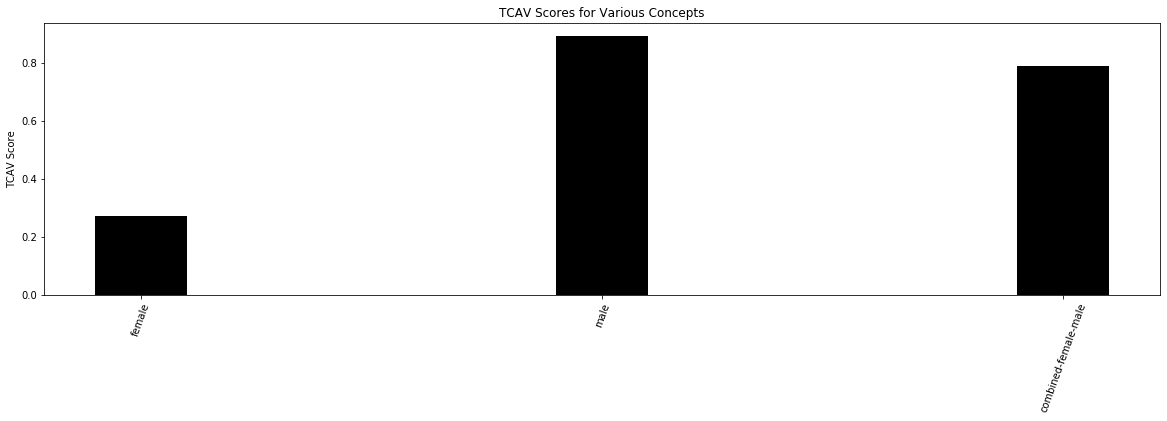

In [58]:
# plot the scores against each concept

x_points = [x for x in range(len(tcavs_dict.keys()))]
keys = list(tcavs_dict.keys())
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(x_points, tcavs_dict.values(), width=0.2, color='k')
plt.xticks(x_points, tcavs_dict.keys(), rotation=70)
plt.title('TCAV Scores for Various Concepts')
plt.ylabel('TCAV Score')
plt.show()

In [19]:
lbls2class = {"0": "female", 
              "1": "male"}

def main():
    for opts in ["concept-vs-other", "concept-vs-random"]:
        for concept_label in ["0", "1"]:
            print(f"Method: {opts}, Concept: {lbls2class[concept_label]}")
            toks, acts = option(opts, concept_label)
            if len(acts) != 0:
                try:
                    X, y, _ = utils.create_tensors(toks, acts, male) # male or female doesn't matter since data is mix, this is a mix.
                except:
                    X = np.array(acts)
                    y = np.array(toks['target'])
            else:
                X, y, _ = utils.create_tensors(toks, activations, male) # male or female doesn't matter since data is mix, this is a mix.

            cavs = get_cavs(X, y)
            
            tcav_dict_positional = {}
            count = 0
            for ix, act in enumerate(base_acts):
                local_count = 0
                local_tcavs_lst = []

                #cav = get_direction(cavs, int(concept_label))
                #mask = act[3] # activation of the MASK
                for ft in act:
                    dydx = compute_direc_derivative(ft, cavs)
                    if dydx: 
                        count += 1
                        
            tcav = float(count)/float(len(base_acts)*len(act))
            print(f"TCAV - {tcav}")
            print("="*50)
            

In [16]:
# need to re-run this.
main()

Method: concept-vs-other, Concept: female
Number of tokens:  1067
TCAV - 0.1154639175257732
Method: concept-vs-other, Concept: male
Number of tokens:  1067
TCAV - 0.1154639175257732
Method: concept-vs-random, Concept: female
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
TCAV - 0.7278350515463917
Method: concept-vs-random, Concept: male
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
TCAV - 0.8938144329896908


## Derivative with [MASK] Word

### Analysis - 1

##### Order: 
    concepts = ["female", "male"]

##### Scores:

Method: concept-vs-other
1. Concept: female
2. TCAV - 0.9329896907216495

Method: concept-vs-other
1. Concept: male
2. TCAV - 0.06701030927835051

Method: concept-vs-random
1. Concept: female
2. TCAV - 0.0

Method: concept-vs-random
1. Concept: male
2. TCAV - 0.5103092783505154

### Analysis - 2

##### Order: 
    concepts = ["male", "female"]

##### Scores:

Method: concept-vs-other
1. Concept: female
2. TCAV - 0.9329896907216495

Method: concept-vs-other
1. Concept: male
2. TCAV - 0.06701030927835051

Method: concept-vs-random
1. Concept: female
2. TCAV - 0.0

Method: concept-vs-random
1. Concept: male
2. TCAV - 0.5103092783505154

## Derivative with each Word in Sentence

##### Scores:

Method: concept-vs-other
1. Concept: female
2. TCAV - 0.8845360824742268

Method: concept-vs-other
1. Concept: male
2. TCAV - 0.1154639175257732

Method: concept-vs-random
1. Concept: female
2. TCAV - 0.7278350515463917

Method: concept-vs-random
1. Concept: male
2. TCAV - 0.8938144329896908